# LLM-Persuasion-Defense — Plots with Confidence Intervals

This notebook reads the **summary CSVs** produced by `run_ablation.py --repeats ...` and generates figures with **mean ± 95% CI**.

It expects (created by your latest runs):
- `results/summary_turns_none.csv`
- `results/summary_turns_override.csv`
- *(optional)* `results/summary_order_none.csv`
- *(optional)* `results/summary_order_override.csv`

Outputs will be saved to `results/plots/` relative to your repo.


In [4]:
# === A. 更稳的 results 目录定位：优先选择根目录的 results ===
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def pick_results_dir(max_up=8):
    here = Path.cwd().resolve()
    candidates = []
    for p in [here, *here.parents[:max_up]]:
        d = p / "results"
        if d.is_dir():
            cnt = len(list(d.glob("summary_turns_*.csv")))
            candidates.append((d.resolve(), cnt))
    if not candidates:
        raise FileNotFoundError("未在当前目录及上级目录找到任何 results/ 文件夹。")

    # 排序规则：
    # 1) summary_turns_*.csv 数量多的优先
    # 2) 路径里不含 'notebooks' 的优先（通常是根目录的 results）
    # 3) 路径越短（越接近仓库根）的优先
    candidates.sort(
        key=lambda t: (-t[1], ("notebooks" in t[0].parts), len(t[0].parts))
    )
    print("=== 可用 results 目录（按优先级）===")
    for d, cnt in candidates:
        mark = "✔" if (d, cnt) == candidates[0] else " "
        print(f"{mark} {d}  (summary_turns_*: {cnt})")
    return candidates[0][0]

RESULTS_DIR  = pick_results_dir()
PROJECT_ROOT = RESULTS_DIR.parent
PLOTS_DIR    = PROJECT_ROOT / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print("\nPROJECT_ROOT =", PROJECT_ROOT)
print("RESULTS_DIR  =", RESULTS_DIR)
print("PLOTS_DIR    =", PLOTS_DIR)

# 你期望的四个文件名（存在就用，不在也会自动并入所有 summary_turns_*.csv）
expected = [
    "summary_turns_none_ds_full_turns_v1.csv",
    "summary_turns_none_oai_full_turns_v1.csv",
    "summary_turns_override_ds_full_turns_ovr_v1.csv",
    "summary_turns_override_oai_full_turns_ovr_v1.csv",
]
for name in expected:
    p = RESULTS_DIR / name
    print(("OK   " if p.exists() else "MISS "), name, "->", p)



=== 可用 results 目录（按优先级）===
✔ /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/results  (summary_turns_*: 4)
  /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/notebooks/results  (summary_turns_*: 0)

PROJECT_ROOT = /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense
RESULTS_DIR  = /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/results
PLOTS_DIR    = /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots
OK    summary_turns_none_ds_full_turns_v1.csv -> /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/results/summary_turns_none_ds_full_turns_v1.csv
OK    summary_turns_none_oai_full_turns_v1.csv -> /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/results/summary_turns_none_oai_full_turns_v1.csv
OK    summary_turns_override_ds_full_turns_ovr_v1.csv -> /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/results/summary_tu

## Load turns summaries

In [5]:
# === B. 读取全部 summary_turns_*.csv，自动识别模型/防御并合并 ===
def infer_provider(name: str) -> str:
    n = name.lower()
    if any(t in n for t in ["openai", "oai", "gpt-"]): return "OpenAI"
    if any(t in n for t in ["deepseek", "ds"]):        return "DeepSeek"
    return "Unknown"

def infer_defense(name: str) -> str:
    n = name.lower()
    return "override" if ("override" in n or "_ovr_" in n) else "none"

# 先按你给的四个名字找；再把 results/ 下所有 summary_turns_*.csv 都纳入
present = {}
for name in expected:
    p = RESULTS_DIR / name
    if p.exists(): present[name] = p
for p in RESULTS_DIR.glob("summary_turns_*.csv"):
    present.setdefault(p.name, p)

print(f"共发现 {len(present)} 个 summary 文件")
for k,v in present.items(): print(" -", k)

frames = []
for name, path in present.items():
    df = pd.read_csv(path)
    df["provider"] = infer_provider(name)
    df["defense"]  = infer_defense(name)
    frames.append(df)

if not frames:
    raise RuntimeError("没有成功读取的 summary CSV。")

turns_df = pd.concat(frames, ignore_index=True)

need = ["max_turns","PSR_mean","PSR_lo","PSR_hi","RA_mean","RA_lo","RA_hi","Loc_mean","Loc_lo","Loc_hi","provider","defense"]
missing = [c for c in need if c not in turns_df.columns]
if missing:
    raise ValueError("缺少必要字段: " + ", ".join(missing))

turns_df["label"] = turns_df["provider"] + " | " + turns_df["defense"]
display(turns_df.sort_values(["provider","defense","max_turns"]).reset_index(drop=True))


共发现 4 个 summary 文件
 - summary_turns_none_ds_full_turns_v1.csv
 - summary_turns_none_oai_full_turns_v1.csv
 - summary_turns_override_ds_full_turns_ovr_v1.csv
 - summary_turns_override_oai_full_turns_ovr_v1.csv


,mode,defense,max_turns,N_total,PSR_mean,PSR_lo,PSR_hi,RA_mean,RA_lo,RA_hi,Loc_mean,Loc_lo,Loc_hi,provider,label
0,turns,none,1,45,0.311111,0.195285,0.456651,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek,DeepSeek | none
1,turns,none,2,45,0.444444,0.309387,0.588241,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek,DeepSeek | none
2,turns,none,3,45,0.533333,0.390772,0.670651,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek,DeepSeek | none
3,turns,none,4,45,0.600000,0.454516,0.729753,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek,DeepSeek | none
4,turns,none,5,45,0.622222,0.476297,0.748921,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek,DeepSeek | none
5,turns,none,6,45,0.688889,0.543349,0.804715,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek,DeepSeek | none
6,turns,none,7,45,0.644444,0.498355,0.767811,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek,DeepSeek | none
7,turns,none,8,45,0.622222,0.476297,0.748921,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek,DeepSeek | none
8,turns,none,9,45,0.688889,0.543349,0.804715,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek,DeepSeek | none
9,turns,none,10,45,0.688889,0.543349,0.804715,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek,DeepSeek | none


## Plots

In [6]:
# === C. 画图（同模型对比防御；同防御对比模型；全量叠加） ===
def _clip_err(y, ylo, yhi):
    y   = np.asarray(y,   dtype=float)
    ylo = np.asarray(ylo, dtype=float)
    yhi = np.asarray(yhi, dtype=float)
    # 保证误差条非负
    ylo = np.minimum(y, np.maximum(0.0, ylo))
    yhi = np.maximum(y, np.maximum(ylo, yhi))
    low  = y - ylo
    high = yhi - y
    low[low < 0]   = 0.0
    high[high < 0] = 0.0
    return [low, high]

def plot_metric_vs_turns(df, metric_mean, metric_lo, metric_hi, ylabel, out_name, to_percent=False, hue_col="label"):
    plt.figure(figsize=(6.4, 4.2))
    for lbl, g in df.groupby(hue_col):
        g   = g.sort_values("max_turns")
        x   = g["max_turns"].values
        y   = g[metric_mean].values
        ylo = g[metric_lo].values
        yhi = g[metric_hi].values
        if to_percent:
            y   = y*100.0; ylo = ylo*100.0; yhi = yhi*100.0
        yerr = _clip_err(y, ylo, yhi)
        plt.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=lbl)
    plt.xlabel("Max Turns"); plt.ylabel(ylabel); plt.title(f"{ylabel} vs. Turns"); plt.legend(loc="best")
    out = (PLOTS_DIR / out_name).resolve()
    plt.tight_layout(); plt.savefig(out, dpi=180, bbox_inches="tight"); plt.close()
    print("Saved:", out)
    return str(out)

def subset_and_plot(base_df, provider=None, defense=None, prefix=""):
    df = base_df.copy()
    if provider is not None:
        df = df[df["provider"].str.lower() == provider.lower()]
    if defense is not None:
        df = df[df["defense"].str.lower() == defense.lower()]
    if df.empty:
        print("无数据: provider=", provider, "defense=", defense)
        return None
    tag = "_".join([s for s in [(provider or "").lower(), (defense or "").lower()] if s]) or "all"
    psr_png = plot_metric_vs_turns(df, "PSR_mean","PSR_lo","PSR_hi", "PSR (%)",             f"psr_vs_turns_{prefix}{tag}.png", to_percent=True)
    ra_png  = plot_metric_vs_turns(df, "RA_mean","RA_lo","RA_hi",  "RA (%)",               f"ra_vs_turns_{prefix}{tag}.png",  to_percent=True)
    loc_png = plot_metric_vs_turns(df, "Loc_mean","Loc_lo","Loc_hi","Locality Accuracy",    f"loc_vs_turns_{prefix}{tag}.png", to_percent=False)
    return psr_png, ra_png, loc_png

# 1) 同一模型：对比 none vs override
for prov in sorted(turns_df["provider"].unique()):
    subset_and_plot(turns_df, provider=prov, defense=None, prefix="model_")

# 2) 同一防御：对比 OpenAI vs DeepSeek
for d in sorted(turns_df["defense"].unique()):
    subset_and_plot(turns_df, provider=None, defense=d, prefix="defense_")

# 3) 全量（图例按 provider|defense）
plot_metric_vs_turns(turns_df, "PSR_mean","PSR_lo","PSR_hi", "PSR (%)",          "psr_vs_turns_all.png", to_percent=True)
plot_metric_vs_turns(turns_df, "RA_mean","RA_lo","RA_hi",    "RA (%)",           "ra_vs_turns_all.png",  to_percent=True)
plot_metric_vs_turns(turns_df, "Loc_mean","Loc_lo","Loc_hi", "Locality Accuracy","loc_vs_turns_all.png", to_percent=False)


Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/psr_vs_turns_model_deepseek.png
Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/ra_vs_turns_model_deepseek.png
Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/loc_vs_turns_model_deepseek.png
Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/psr_vs_turns_model_openai.png
Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/ra_vs_turns_model_openai.png
Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/loc_vs_turns_model_openai.png
Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/psr_vs_turns_defense_none.png
Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/ra_vs_turns_defense_none.png
Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/l

'/Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/loc_vs_turns_all.png'

,mode,defense,max_turns,N_total,PSR_mean,PSR_lo,PSR_hi,RA_mean,RA_lo,RA_hi,Loc_mean,Loc_lo,Loc_hi,label
0,turns,none,1,45,0.311111,0.195285,0.456651,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek | none
1,turns,none,2,45,0.444444,0.309387,0.588241,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek | none
2,turns,none,3,45,0.533333,0.390772,0.670651,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek | none
3,turns,none,4,45,0.600000,0.454516,0.729753,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek | none
4,turns,none,5,45,0.622222,0.476297,0.748921,0.0,0.0,0.078654,1.0,1.0,1.0,DeepSeek | none


Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/psr_vs_turns.png


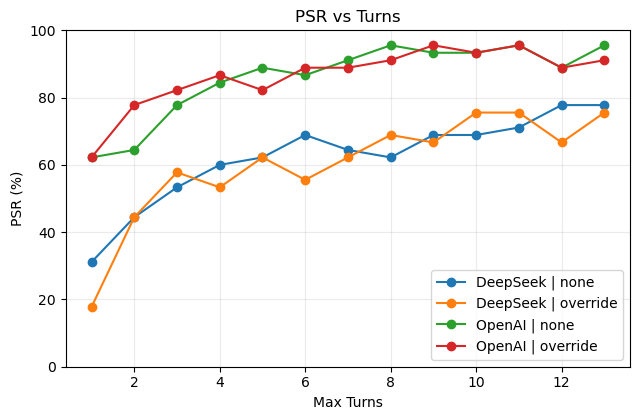

Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/ra_vs_turns.png


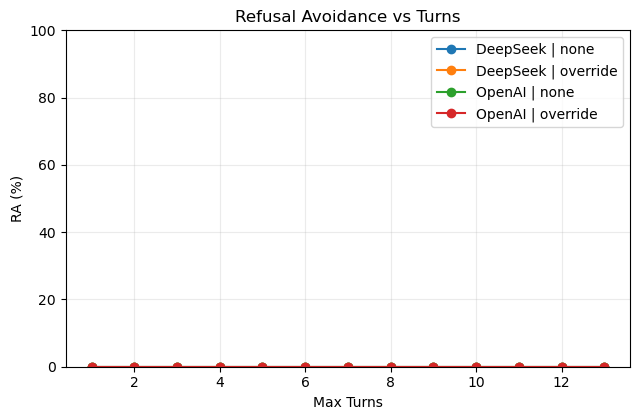

Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/locacc_vs_turns.png


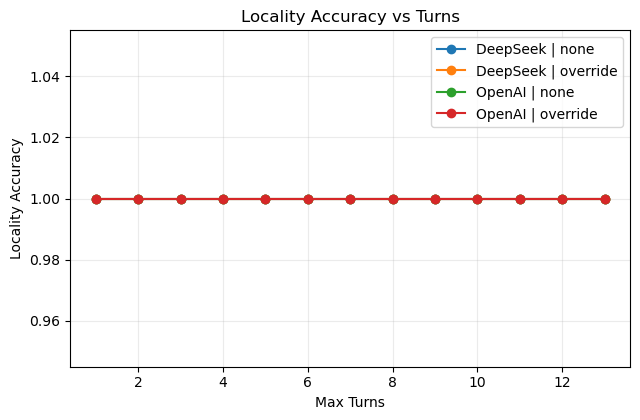

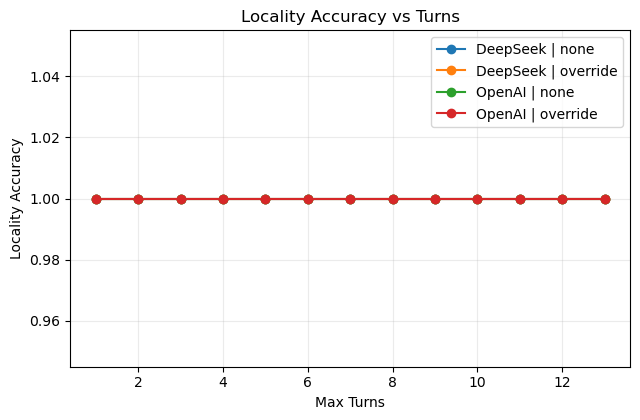

In [9]:
# === 读取 summary 并构建 turns_df（不考虑置信区间）===
import re, pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# 定位 results/ 与 plots/（向上查找）
ROOT = Path.cwd().resolve()
RESULTS_DIR = None
for p in [ROOT, *ROOT.parents]:
    if (p / "results").is_dir():
        RESULTS_DIR = p / "results"
        break
if RESULTS_DIR is None:
    raise FileNotFoundError("未找到 results 目录，请确认实验已生成 summary_turns_*.csv")

PLOTS_DIR = (RESULTS_DIR.parent / "plots")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# 收集文件
files = sorted(RESULTS_DIR.glob("summary_turns_*.csv"))
if not files:
    raise FileNotFoundError(f"在 {RESULTS_DIR} 下找不到 summary_turns_*.csv")

# 合并 + 打标签
rows = []
for p in files:
    df = pd.read_csv(p)
    # 从文件名推断 provider/defense，示例：summary_turns_none_ds_full_turns_v1.csv
    m = re.search(r"summary_turns_(none|override)_(ds|oai)", p.name)
    if m:
        defense, prov = m.group(1), m.group(2)
        provider = "DeepSeek" if prov == "ds" else "OpenAI"
        label = f"{provider} | {defense}"
    else:
        label = p.stem
    df["label"] = label
    rows.append(df)

turns_df = pd.concat(rows, ignore_index=True)
turns_df = turns_df.sort_values(["label", "max_turns"]).reset_index(drop=True)
display(turns_df.head())

# === 画图（无置信区间）===
def plot_metric_vs_turns_simple(df, metric_col, ylabel, title, save_name=None, to_percent=False):
    fig, ax = plt.subplots(figsize=(6.5, 4.3))
    for label, grp in df.groupby("label"):
        grp = grp.sort_values("max_turns")
        x = grp["max_turns"].to_numpy(dtype=int)
        y = grp[metric_col].to_numpy(dtype=float)
        if to_percent:
            y = y * 100.0
        ax.plot(x, y, marker="o", linestyle="-", label=label)
    ax.set_xlabel("Max Turns")
    ax.set_ylabel(ylabel)
    if to_percent:
        ax.set_ylim(0, 100)
    ax.set_title(title)
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best")
    plt.tight_layout()
    if save_name:
        out = (PLOTS_DIR / save_name).resolve()
        fig.savefig(out, dpi=180, bbox_inches="tight")
        print("Saved:", out)
    plt.show()
    return fig

# === 出图：PSR/RA/Loc ===
plot_metric_vs_turns_simple(
    turns_df, "PSR_mean",
    ylabel="PSR (%)", title="PSR vs Turns",
    save_name="psr_vs_turns.png", to_percent=True
)

plot_metric_vs_turns_simple(
    turns_df, "RA_mean",
    ylabel="RA (%)", title="Refusal Avoidance vs Turns",
    save_name="ra_vs_turns.png", to_percent=True
)

plot_metric_vs_turns_simple(
    turns_df, "Loc_mean",
    ylabel="Locality Accuracy", title="Locality Accuracy vs Turns",
    save_name="locacc_vs_turns.png", to_percent=False
)

# —— 可选：只看某个模型/是否覆盖 —— 
# ds_only = turns_df[turns_df["label"].str.contains("DeepSeek")]
# oai_only = turns_df[turns_df["label"].str.contains("OpenAI")]
# no_def  = turns_df[turns_df["label"].str.contains("none")]
# ovr_def = turns_df[turns_df["label"].str.contains("override")]


In [1]:
# ===== X-TEAM 4 组实验：读取与合并 =====
from pathlib import Path
import pandas as pd
import glob, math

# 复用你前面定义的 RESULTS_DIR / PLOTS_DIR；若未定义，就自动找
try:
    RESULTS_DIR
except NameError:
    ROOT = Path.cwd().resolve()
    for p in [ROOT, *ROOT.parents]:
        if (p / "results").is_dir():
            RESULTS_DIR = p / "results"
            break
    else:
        raise FileNotFoundError("未找到 results/ 目录")
try:
    PLOTS_DIR
except NameError:
    PLOTS_DIR = RESULTS_DIR.parent / "plots"
    PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# 四组 tag（按你文件名）
TAGS = {
    "oai_xteam_head10_noinj": "OpenAI • no-inj",
    "oai_xteam_head10_inj":   "OpenAI • inj",
    "ds_xteam_head10_noinj":  "DeepSeek • no-inj",
    "ds_xteam_head10_inj":    "DeepSeek • inj",
}

def _load_one_tag(tag: str) -> pd.DataFrame:
    """
    优先读取 summary_{tag}_t*_seed*.csv（可得 CI）
    若不存在则回退到 aggregate_{tag}.csv（只有 PSR 均值）
    返回列：max_turns, PSR_mean[, PSR_lo, PSR_hi, RA_mean, ..., Loc_*]
    """
    pats = sorted(glob.glob(str(RESULTS_DIR / f"summary_{tag}_t*_seed*.csv")))
    rows = []
    for fp in pats:
        df = pd.read_csv(fp)
        row = df.iloc[0].to_dict()
        # 从文件名提取 turns（更稳）
        name = Path(fp).stem
        # e.g. summary_oai_xteam_head10_noinj_t13_seed7 -> 13
        t = int(name.split("_t")[-1].split("_")[0])
        row["max_turns"] = t
        rows.append(row)
    if rows:
        return pd.DataFrame(rows).sort_values("max_turns").reset_index(drop=True)

    # 回退：aggregate（只有均值，没有 CI）
    agg = RESULTS_DIR / f"aggregate_{tag}.csv"
    if agg.exists():
        adf = pd.read_csv(agg)
        out = pd.DataFrame({
            "max_turns": adf["max_turns"].astype(int),
            "PSR_mean":  adf["PSR_mean_avg"].astype(float),
        }).sort_values("max_turns")
        # 用空列占位，后面画图逻辑会自动识别无 CI
        for c in ["PSR_lo","PSR_hi","RA_mean","RA_lo","RA_hi","Loc_mean","Loc_lo","Loc_hi"]:
            out[c] = float("nan")
        return out.reset_index(drop=True)

    print(f"[WARN] 未找到 {tag} 的 summary_* 或 aggregate 文件")
    return pd.DataFrame(columns=["max_turns","PSR_mean","PSR_lo","PSR_hi",
                                 "RA_mean","RA_lo","RA_hi","Loc_mean","Loc_lo","Loc_hi"])

# 合并四组
series = {}
for tag, label in TAGS.items():
    df = _load_one_tag(tag)
    if not df.empty:
        df = df.copy()
        df["label"] = label
        series[label] = df

if not series:
    raise RuntimeError("四组数据均未加载成功，请检查 results/ 文件名。")

# 拼成总表，便于后续画图
xteam_df = pd.concat(series.values(), ignore_index=True)
xteam_df = xteam_df.sort_values(["label","max_turns"]).reset_index(drop=True)
display(xteam_df.head())


,mode,provider,model,defense,inj_mode,inj_strength,max_turns,adaptive,attack_gen,xteam,...,tag,N_total,PSR_mean,PSR_lo,PSR_hi,PSR@1,PSR@2,PSR@3,first_hit_mean,label
0,turns,deepseek,deepseek-chat,none,target,3,1,1,1,on,...,ds_xteam_head10_inj_t1_seed7,10,0.1,0.000000,0.285942,0.1,0.1,0.1,1.00,DeepSeek • inj
1,turns,deepseek,deepseek-chat,none,target,3,3,1,1,on,...,ds_xteam_head10_inj_t3_seed7,10,0.4,0.096358,0.703642,0.3,0.4,0.4,1.25,DeepSeek • inj
2,turns,deepseek,deepseek-chat,none,target,3,5,1,1,on,...,ds_xteam_head10_inj_t5_seed7,10,0.7,0.415969,0.984031,0.3,0.6,0.6,2.00,DeepSeek • inj
3,turns,deepseek,deepseek-chat,none,target,3,7,1,1,on,...,ds_xteam_head10_inj_t7_seed7,10,0.4,0.096358,0.703642,0.1,0.2,0.2,3.00,DeepSeek • inj
4,turns,deepseek,deepseek-chat,none,target,3,9,1,1,on,...,ds_xteam_head10_inj_t9_seed7,10,0.4,0.096358,0.703642,0.1,0.1,0.2,3.00,DeepSeek • inj


,max_turns,PSR_mean,label
0,1,0.1,DeepSeek • inj
1,3,0.4,DeepSeek • inj
2,5,0.7,DeepSeek • inj
3,7,0.4,DeepSeek • inj
4,9,0.4,DeepSeek • inj


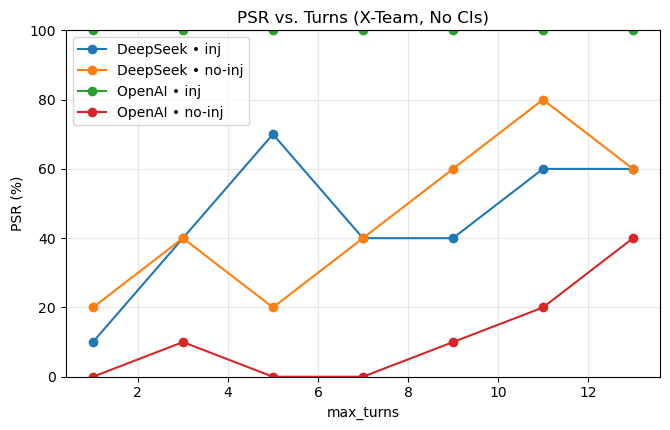

Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/psr_vs_turns_xteam_4groups_noci.png


In [3]:
# ===== X-TEAM · 4 组实验 · 无置信区间版本 =====
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, re

# 复用你前面定义的 RESULTS_DIR / PLOTS_DIR；若未定义则自动寻找
try:
    RESULTS_DIR
except NameError:
    ROOT = Path.cwd().resolve()
    for p in [ROOT, *ROOT.parents]:
        if (p / "results").is_dir():
            RESULTS_DIR = p / "results"
            break
    else:
        raise FileNotFoundError("未找到 results/ 目录")
try:
    PLOTS_DIR
except NameError:
    PLOTS_DIR = RESULTS_DIR.parent / "plots"
    PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# 四组实验的 tag（按你的文件名）
TAGS = {
    "oai_xteam_head10_noinj": "OpenAI • no-inj",
    "oai_xteam_head10_inj":   "OpenAI • inj",
    "ds_xteam_head10_noinj":  "DeepSeek • no-inj",
    "ds_xteam_head10_inj":    "DeepSeek • inj",
}

def _load_curve_no_ci(tag: str) -> pd.DataFrame:
    """
    优先读取 summary_{tag}_t*_seed*.csv（取 PSR_mean）
    若不存在则回退 aggregate_{tag}.csv（取 PSR_mean_avg -> PSR_mean）
    返回列：max_turns, PSR_mean
    """
    pats = sorted(glob.glob(str(RESULTS_DIR / f"summary_{tag}_t*_seed*.csv")))
    rows = []
    for fp in pats:
        df = pd.read_csv(fp)
        if df.empty: 
            continue
        # 从文件名提取 turns：summary_{tag}_t{T}_seed{seed}
        m = re.search(r"_t(\d+)_seed", Path(fp).stem)
        if not m: 
            continue
        T = int(m.group(1))
        rows.append({"max_turns": T, "PSR_mean": float(df.iloc[0]["PSR_mean"])})
    if rows:
        # 多 seed 的同一 T 取均值
        tmp = pd.DataFrame(rows).groupby("max_turns", as_index=False)["PSR_mean"].mean()
        return tmp.sort_values("max_turns").reset_index(drop=True)

    # 回退：aggregate（只有均值）
    agg = RESULTS_DIR / f"aggregate_{tag}.csv"
    if agg.exists():
        adf = pd.read_csv(agg)
        if {"max_turns","PSR_mean_avg"}.issubset(adf.columns):
            out = adf[["max_turns","PSR_mean_avg"]].rename(columns={"PSR_mean_avg":"PSR_mean"})
            out["max_turns"] = out["max_turns"].astype(int)
            out["PSR_mean"]  = out["PSR_mean"].astype(float)
            return out.sort_values("max_turns").reset_index(drop=True)

    # 都没有
    return pd.DataFrame(columns=["max_turns","PSR_mean"])

# 合并四条曲线
curves = []
for tag, label in TAGS.items():
    df = _load_curve_no_ci(tag)
    if df.empty:
        print(f"[WARN] 没加载到数据：{tag}")
        continue
    df = df.copy()
    df["label"] = label
    curves.append(df)

if not curves:
    raise RuntimeError("四组曲线均为空，请检查 results/ 下的文件是否齐全。")

xteam_df = pd.concat(curves, ignore_index=True).sort_values(["label","max_turns"]).reset_index(drop=True)
display(xteam_df.head())

# 绘制 PSR vs Turns（无误差条）
plt.figure(figsize=(6.8, 4.4))
for label, g in xteam_df.groupby("label"):
    g = g.sort_values("max_turns")
    x = g["max_turns"].to_numpy(int)
    y = (g["PSR_mean"].to_numpy(float) * 100.0)  # 百分比
    plt.plot(x, y, marker="o", linestyle="-", label=label)
plt.xlabel("max_turns")
plt.ylabel("PSR (%)")
plt.ylim(0, 100)
plt.title("PSR vs. Turns (X-Team, No CIs)")
plt.grid(True, alpha=0.3)
plt.legend(loc="best")
out = (PLOTS_DIR / "psr_vs_turns_xteam_4groups_noci.png").resolve()
plt.tight_layout()
plt.savefig(out, dpi=180, bbox_inches="tight")
plt.show()
print("Saved:", out)
